In [3]:
import os
import pickle
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Import data

In [4]:
# Initialize dictionaries to store accumulated metrics
method_metrics = defaultdict(lambda: defaultdict(list))

# Folder path containing the .pkl files
folder_path = './metrics_outliers/'

# Iterate through files in the folder
for file_name in os.listdir(folder_path):
    if file_name.endswith('.pkl'):
        # Parse method and p value from file name
        method, floor_p = file_name.split('_')[0], file_name.split('_')[2]
        p_value = int(floor_p[1:-4])
        
        # Load pickle file and extract metrics dictionary
        with open(os.path.join(folder_path, file_name), 'rb') as file:
            ad_metrics = pickle.load(file)
        
        # Accumulate metrics for each method and p value
        for metric, value in ad_metrics.items():
             method_metrics[(method, p_value)][metric].append(value)


In [5]:
# Calculate average metrics for each method and p value
average_metrics = defaultdict(lambda: defaultdict(float))

for method_p, metrics in method_metrics.items():
    method, p_value = method_p
    for metric, values in metrics.items():
        average_metrics[(method, p_value)][metric] = sum(values) / len(values)

# visualize metrics

## prediction scores

In [6]:
# Create subplots for each p value
num_p_values = len(set([p for (method, p) in average_metrics.keys()]))

In [7]:
metric_names = ['Accuracy', 'Precision', 'Recall',  'F1 Score', 'Mean Squared Error', 'Mean Absolute Error', 'Adjusted Rand Index', 'Davies-Bouldin Index', 'Calinski-Harabasz Index', 'Homogeneity', 'Completeness', 'V-measure']

In [8]:
# metric_names = set(metric for method, p in average_metrics.keys() for metric in average_metrics[method, p].keys() 
                          # if metric not in ['Confusion Matrix', 'FPR', 'TPR', 'ROC AUC'])
method_names = ['ensemble', 'ood', 'kmeans', 'dbscan']

In [40]:
method_label_mapping = {
    'kmeans': 'K-means',
    'dbscan': 'DBSCAN',
    'ensemble': 'EIF-FL',
    'ood': 'OOD'
}
method_colors = {
    'kmeans': 'orange',
    'dbscan': 'green',
    'ensemble': 'blue',
    'ood': 'olive'
}

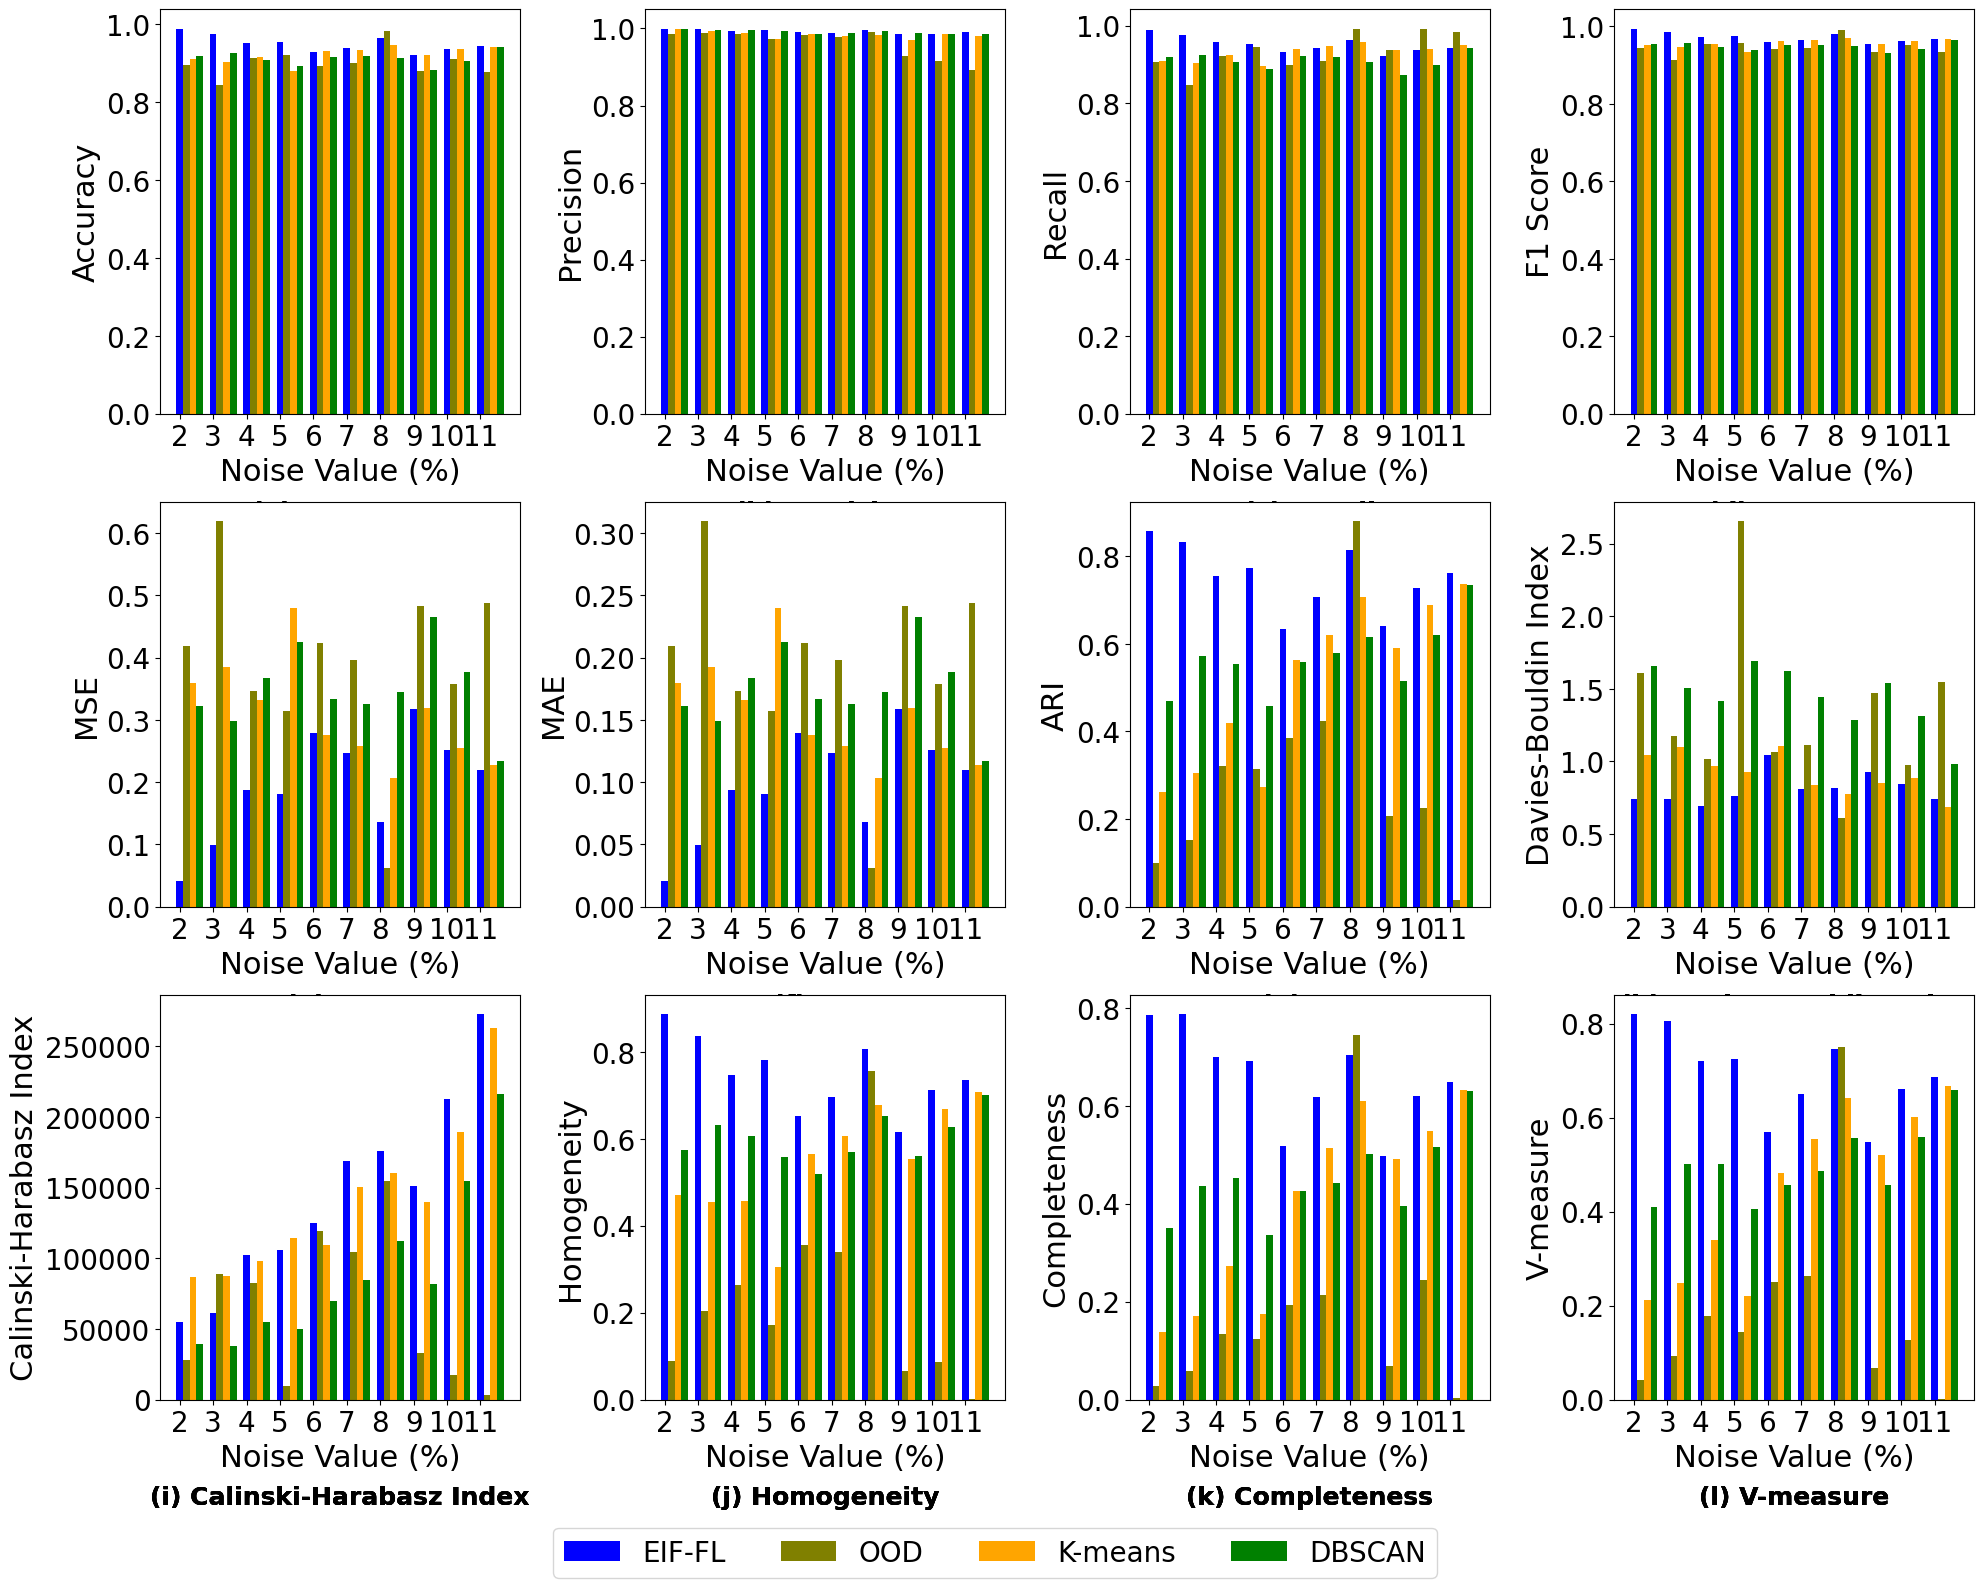

In [41]:
num_rows = 3  # number of rows
num_cols = 4  # number of columns

# Define a mapping for metric name replacements
metric_name_mapping = {
    'Mean Absolute Error': 'MAE',
    'Mean Squared Error': 'MSE',
    'Adjusted Rand Index': 'ARI'
}

fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 5 * num_rows))
subplot_labels = [f"({chr(97 + i)})" for i in range(num_rows * num_cols)]  # Generate labels: a), b), c), ...

# Collect handles and labels for the global legend
handles = []
labels = []

for i, metric_name in enumerate(metric_names):
    # Replace metric_name with its short form if it exists in the mapping
    short_metric_name = metric_name_mapping.get(metric_name, metric_name)
    
    metric = {method_p: metrics for method_p, metrics in average_metrics.items() if metric_name in metrics}
    row = i // num_cols
    col = i % num_cols
    for method_idx, method in enumerate(method_names):
        ax = axes[row, col] if num_rows > 1 else axes[col]
        p_values = [p + method_idx * 0.2 for (m, p) in metric.keys() if m == method]
        metric_values = [v[metric_name] for (m, p), v in metric.items() if m == method]
        label = method_label_mapping.get(method, method)
        color = method_colors.get(method, 'black')
        
        # Plot the bars and collect the handle and label for legend
        bar = ax.bar(p_values, metric_values, label=label, width=0.2, color=color)
        if label not in labels:
            handles.append(bar[0])  # Append the handle (bar object)
            labels.append(label)    # Append the label

        ax.set_xlabel('Noise Value (%)', fontsize=22)
        ax.set_ylabel(short_metric_name, fontsize=22)
        ax.set_xticks([2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
        ax.text(0.5, -0.26, subplot_labels[i] + ' ' + short_metric_name, 
                fontsize=18, weight='bold', ha='center', transform=ax.transAxes)

        ax.tick_params(axis='x', labelsize=20)
        ax.tick_params(axis='y', labelsize=20)

# Add a single horizontal legend at the bottom of the figure
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.07), 
           ncol=len(labels), fontsize=20)

plt.subplots_adjust(hspace=4.5)
plt.tight_layout()
plt.show()


## auc roc curve

In [29]:
# Create subplots for each metric
num_rows = 5  # number of rows
num_cols = 2  # number of columns

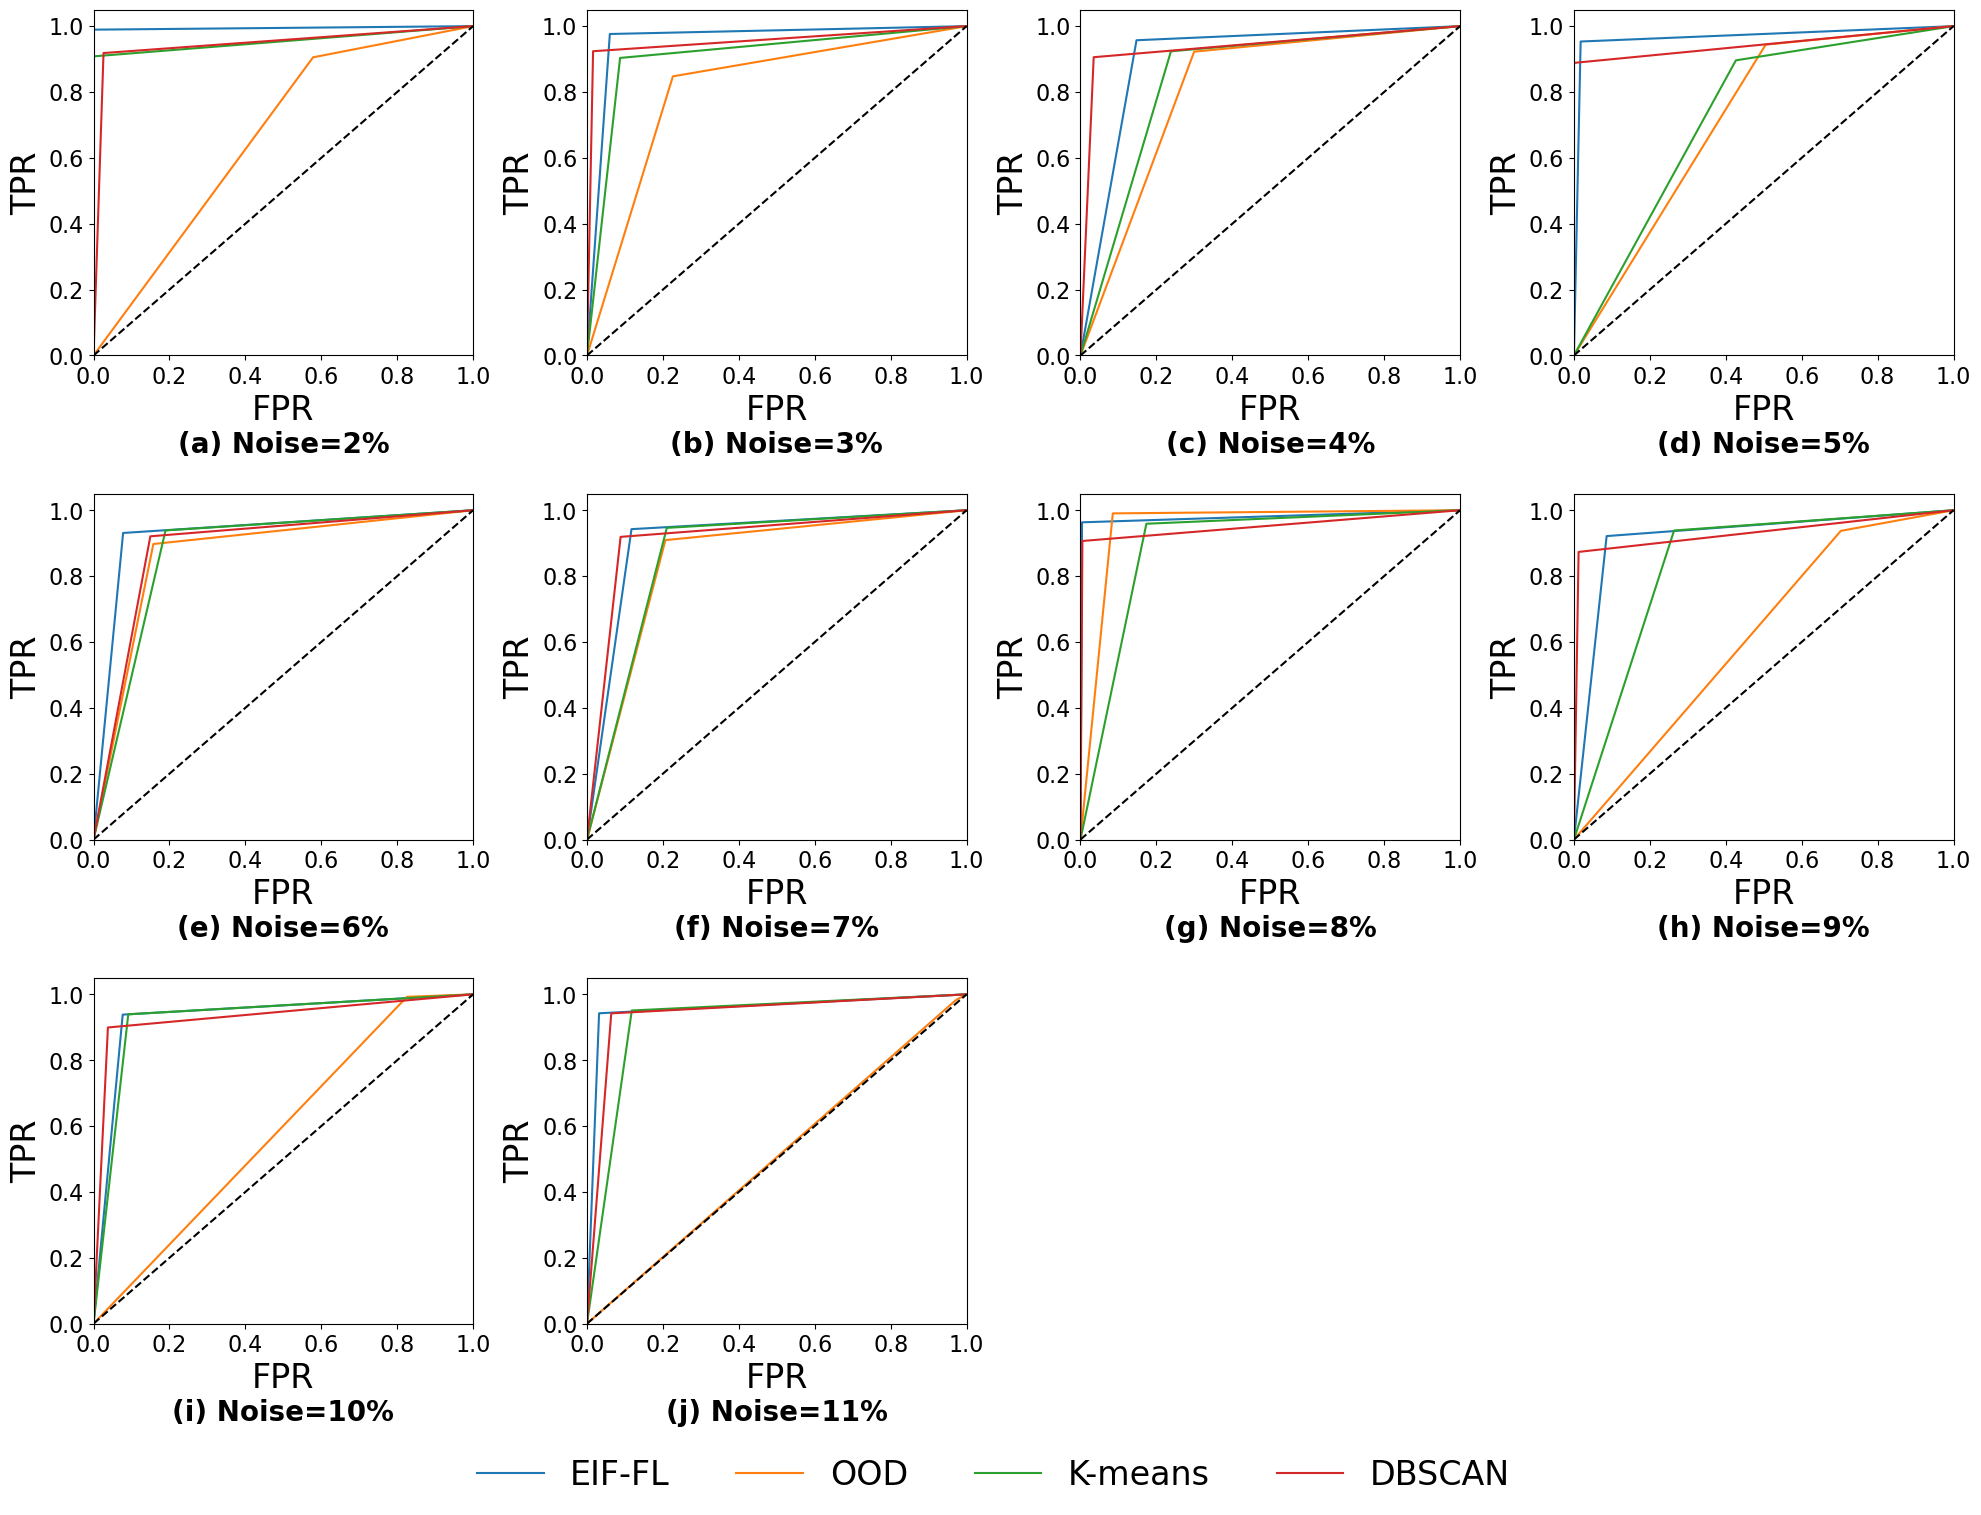

In [66]:
# Create subplots with only as many rows as needed
fig, axes = plt.subplots(num_rows, num_cols, figsize=(6 * num_cols, 6 * num_rows))
subplot_labels = [f"({chr(97 + i)})" for i in range(num_p_values)]  # Generate labels: a), b), c), ...

# Collect handles and labels for the global legend
handles = []
labels = []

# Iterate through p-values and generate ROC curves
for idx, (p_value, ax) in enumerate(zip(sorted(set([p for (method, p) in average_metrics.keys()])), axes.flat)):
    for method in method_names:
        fpr = average_metrics[(method, p_value)]['FPR']
        tpr = average_metrics[(method, p_value)]['TPR']
        
        # Use the mapping to get the correct label
        label = method_label_mapping.get(method, method)
        
        # Plot ROC curve and collect handles/labels
        curve, = ax.plot(fpr, tpr, label=label)
        if label not in labels:  # Prevent duplicate labels
            handles.append(curve)
            labels.append(label)

    ax.plot([0, 1], [0, 1], linestyle='--', color='k', label='Random')  # Random curve
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('FPR', fontsize=24)
    ax.set_ylabel('TPR', fontsize=24)

    # Add subplot text below each figure
    ax.text(0.5, -0.28, subplot_labels[idx] + f' Noise={p_value}%', 
            fontsize=20, ha='center', transform=ax.transAxes, weight='bold')

    # Set the font size for x and y ticks
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)

# Hide empty subplots if necessary
if num_rows * num_cols > num_p_values:
    for i in range(num_p_values, num_rows * num_cols):
        axes.flat[i].axis('off')

# Add a single horizontal legend at the bottom of the figure
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5,0.04), 
           ncol=len(labels), fontsize=24, frameon=False)

# Adjust spacing between rows and leave room for text
plt.subplots_adjust(hspace=0.4, wspace=0.3, bottom=0.15)

plt.show()


# Execution time and memory

In [45]:
# time_per_loop_seconds = [37.9, 17 * 60 + 56, 3 * 60 + 48, 29 * 60 + 49]  # converted to seconds
# peak_memory_mib = [628.79, 25939.56, 977.08, 1048.61]
time_per_loop_seconds = [57.9, 9 * 60 + 44, 1 * 60 + 48, 29 * 60 + 49]  # converted to seconds
peak_memory_mib = [628.79, 12743.78, 620.28, 720.78]

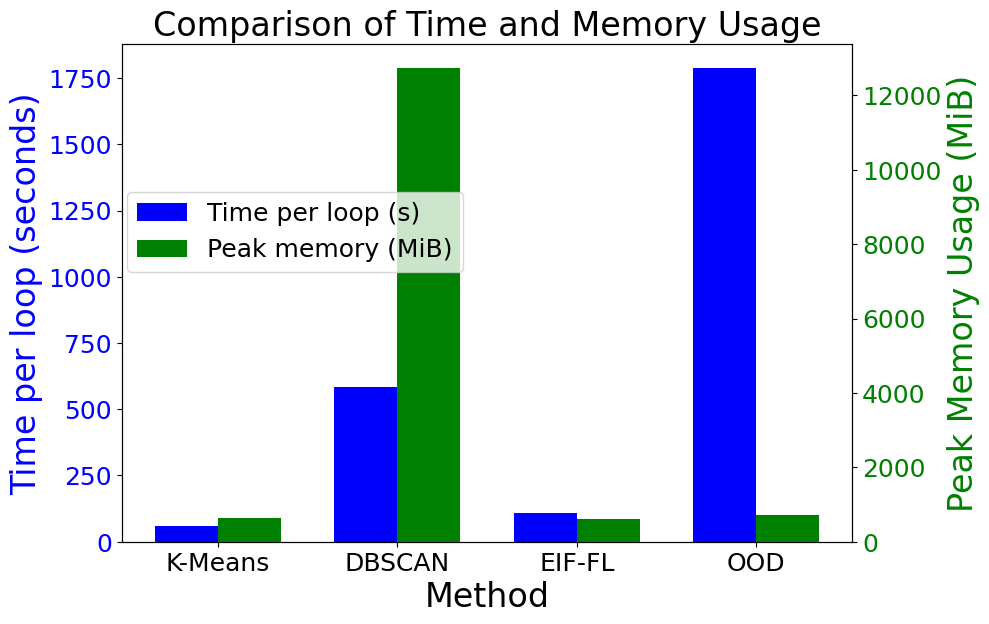

In [60]:
method = ['K-Means', 'DBSCAN', 'EIF-FL', 'OOD']
# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar width
bar_width = 0.35
x = np.arange(len(method))

# Plotting time per loop
color1 = 'blue'
bar1 = ax1.bar(x - bar_width/2, time_per_loop_seconds, bar_width, label='Time per loop (s)', color=color1)
ax1.set_xlabel('Method', fontsize=24)
ax1.set_ylabel('Time per loop (seconds)', color=color1, fontsize=24)
ax1.set_xticks(x)
ax1.set_xticklabels(method)
ax1.tick_params(axis='y', labelcolor=color1, labelsize=18)
ax1.tick_params(axis='x', labelsize=18)

# Creating a twin axis for memory usage
ax2 = ax1.twinx()
color2 = 'green'
bar2 = ax2.bar(x + bar_width/2, peak_memory_mib, bar_width, label='Peak memory (MiB)', color=color2)
ax2.set_ylabel('Peak Memory Usage (MiB)', color=color2, fontsize=24)
ax2.tick_params(axis='y', labelcolor=color2, labelsize=18)
ax2.tick_params(axis='x', labelsize=18)

# Adding legend
fig.tight_layout()
fig.legend(loc='upper right', bbox_to_anchor=(0.48, 0.75), fontsize=18)


plt.title('Comparison of Time and Memory Usage', fontsize=24)
plt.show()

# confusion matrix

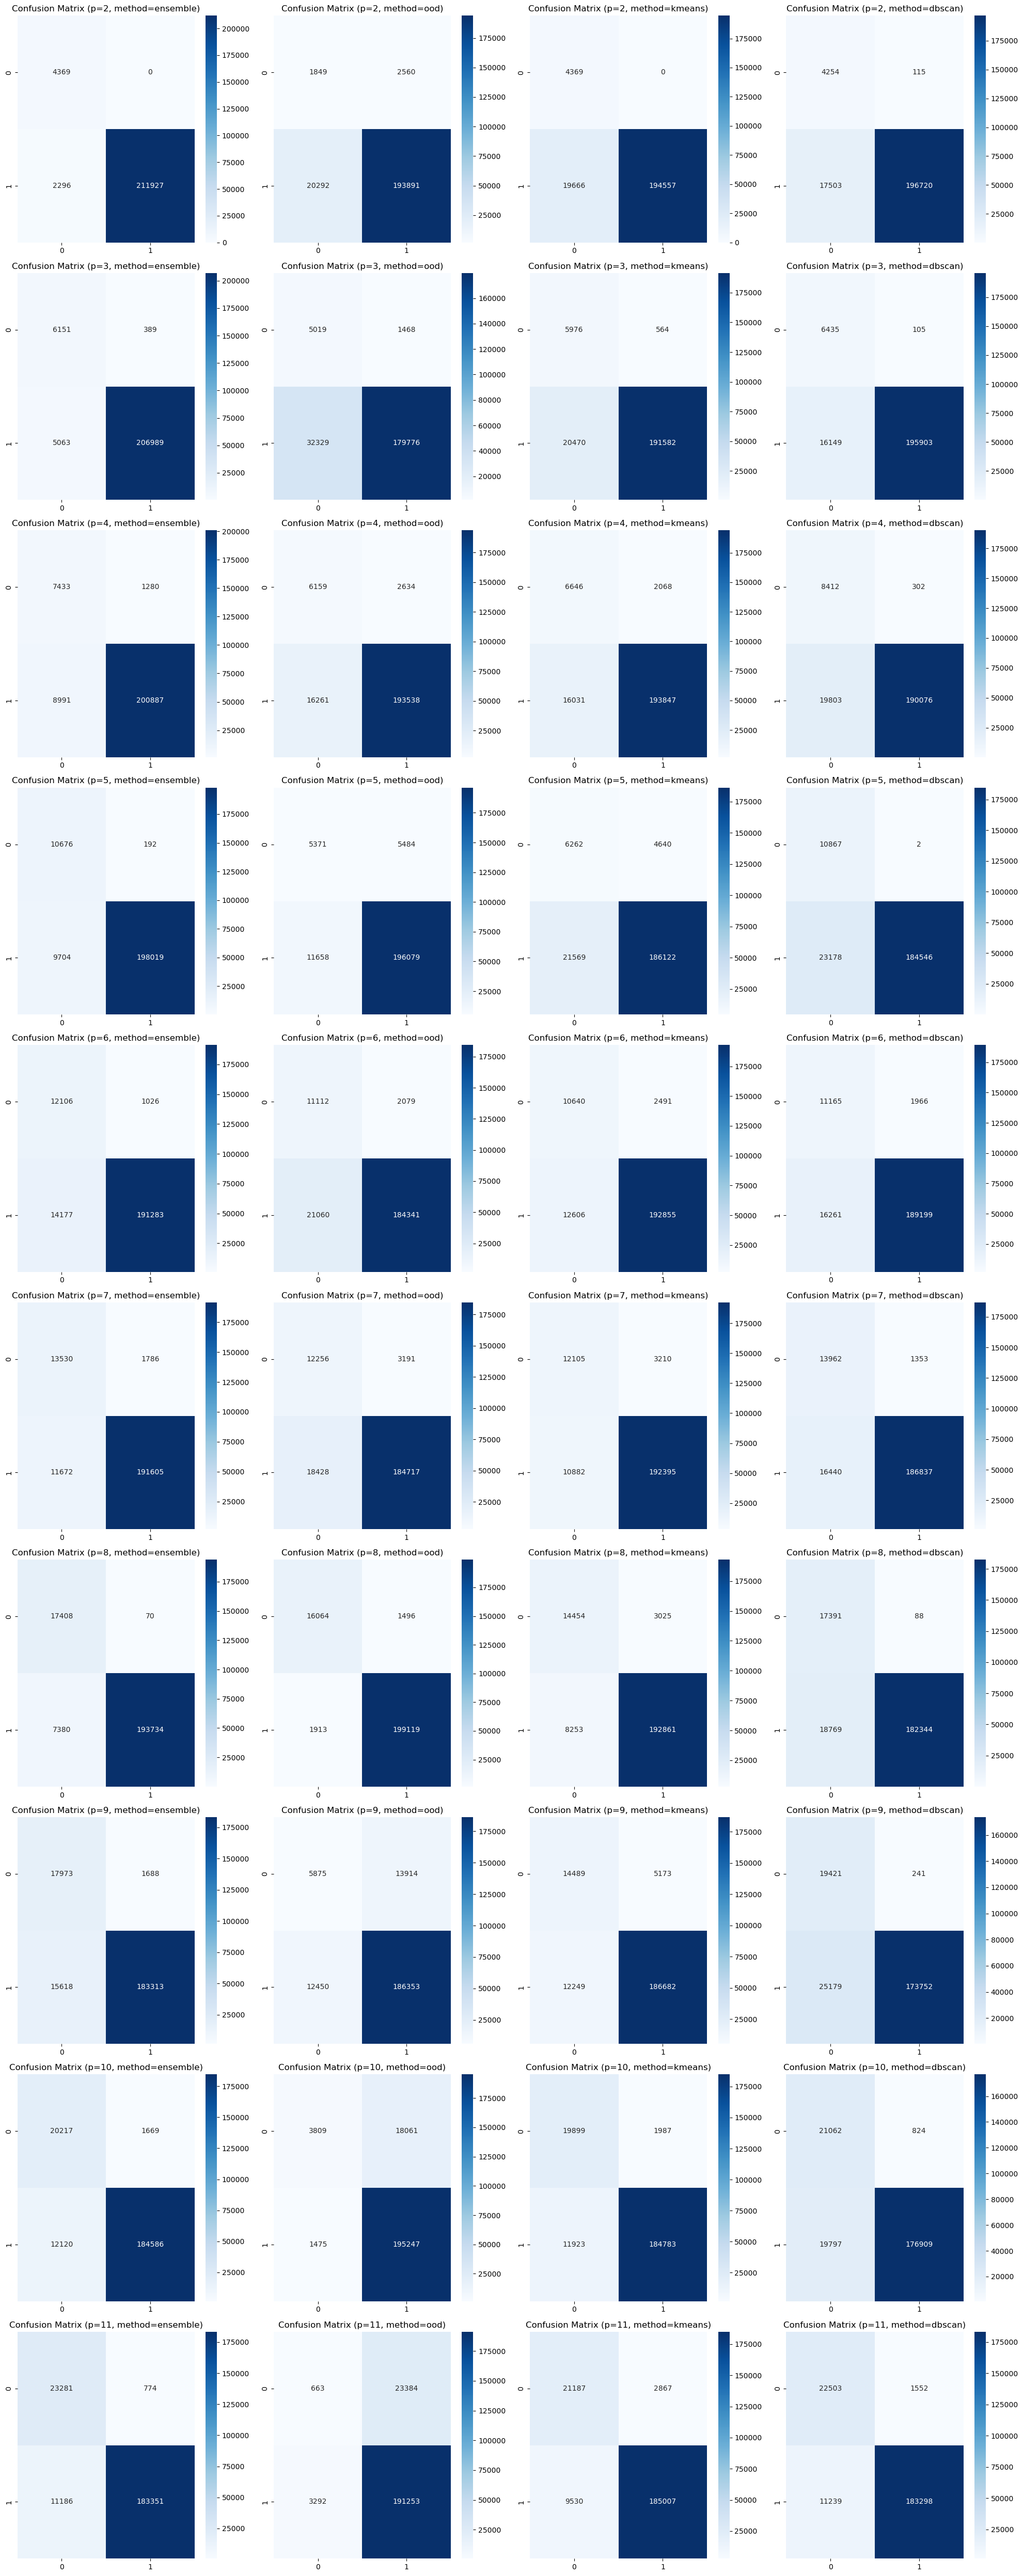

In [26]:
# Create subplots for each p value
num_p_values = len(set([p for (method, p) in average_metrics.keys()]))
num_methods = len(method_names)
num_cols = num_methods  # Number of columns for subplots
num_rows = num_p_values  # Number of rows for subplots

fig, axes = plt.subplots(num_rows, num_cols, figsize=(5*num_methods, 5*num_p_values))

for i, (p_value, ax_row) in enumerate(zip(sorted(set([p for (method, p) in average_metrics.keys()])), axes)):
    for j, method in enumerate(method_names):
        conf_matrix = np.round(average_metrics[(method, p_value)]['Confusion Matrix']).astype(int)
        sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', ax=ax_row[j])
        ax_row[j].set_title(f'Confusion Matrix (p={p_value}, method={method})')

plt.tight_layout()
plt.show()